In [1]:
import json
import pandas as pd
import numpy as np
from zipfile import ZipFile
import re
from io import BytesIO
from tqdm import tqdm


In [2]:
def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

def normalize_json(data: dict) -> dict:
  
    new_data = dict()
    for key, value in data.items():
        if not isinstance(value, dict):
            new_data[key] = value
        else:
            for k, v in value.items():
                new_data[key + "_" + k] = v
  
    return new_data
    
def read_files(filepath):
    """Reads file into csv

    Args:
        filepath (str): location of the file to read to csv
    """
    df = []
    ignore_file = '__MACOSX'
    with ZipFile(filepath, "r") as z:
        for filename in z.namelist()[1:]: #Skip root folder folder/
            if ignore_file not in filename:
                    # print(filename)  
                    with z.open(filename, 'r') as f:  
                        data = f.read()  
                        df.append(pd.json_normalize(json.loads(data))) 
                        
    df = pd.concat(df)
    df = df.set_index(df.columns[0]) # Set first column as index

    return df

def read_news_files(filepath, is_fake_news, type_of_file):
    """Extracts data from politifact_fake and politifact_real and converts to dataframe

    Args:
        filepath (str): Zip filepath
        is_fake_news (bool): Zip file classification
        type_of_file (str): subfolder name for the news article for users that have: retweet, likes, tweet, reply

    Returns:
        DataFrame: dataframe
    """
    df = []
    ignore_file = '__MACOSX'
    with ZipFile(filepath, "r") as zip:
        for zipname in tqdm(zip.namelist()[1:]):
            zfiledata = BytesIO(zip.read(zipname))

            with ZipFile(zfiledata, "r") as z:
                for filename in z.namelist(): #Skip root folder folder/
                    if re.search(type_of_file+'/[a-zA-Z0-9].', filename):
                        with z.open(filename, 'r') as f:  
                            data = f.read()
                            # if type_of_file=='asd':
                            #     data = pd.json_normalize(json.loads(data))
                            #     data =data.rename(columns={'id':'user_id'})
                            # else:
                            try:
                                # data = pd.DataFrame(normalize_json(json.loads(data)))
                                data = normalize_json(json.loads(data))
                            except: 
                                print('error on a json')
                                continue
                            data['news_id'] = re.split("\.+", zipname)[0]
                            data['is_fake_news'] = is_fake_news
                            data['tweet_id'] = find_between(filename, '/','.')
                            df.append(data) 
    # df = pd.concat(df)
    df = pd.DataFrame(df)
    return df

def extract_id_from_json(json_col, type_of_file):
    id_list = []

    if type_of_file=='retweets':
        for jsons in tqdm(json_col):
            user_id = json.loads(json.dumps(jsons))['user']['id_str']
            id_list.append(user_id)
            
    elif type_of_file=='replies':
        for jsons in tqdm(json_col):
            user_id = json.loads(json.dumps(jsons))['user_id']
            id_list.append(user_id)

    elif type_of_file=='likes':
        id_list = json_col
   
    elif type_of_file=='tweets':
        for jsons in tqdm(json_col):
            user_id = json.loads(json.dumps(jsons))['user']['id_str']
            id_list.append(user_id)

    return id_list

In [3]:
# df_followers = read_files('user_followers.zip')
# df_followers = df_followers.explode('followers')
# df_followers = df_followers.reset_index()

# df_following = read_files('user_following.zip')
# df_following = df_following.explode('followees')
# df_following = df_following.reset_index()

# df_user_profiles = read_files('user_profiles.zip')

# news_retweet_fake = read_news_files('politifact_fake.zip', is_fake_news=1, type_of_file='retweets')
# news_retweet_fake = news_retweet_fake[news_retweet_fake['retweets'].map(lambda d: len(d)) > 0]
# news_retweet_fake['retweets'] = news_retweet_fake['retweets'].map(lambda x: x[0])
# news_retweet_fake['user_id'] = extract_id_from_json(news_retweet_fake.retweets.tolist(), type_of_file='retweets')

# news_likes_fake = read_news_files('politifact_fake.zip', is_fake_news=1, type_of_file='likes')
news_tweet_fake = read_news_files('politifact_fake.zip', is_fake_news=1, type_of_file='tweets')
news_tweet_fake['user_id'] =  news_tweet_fake['id_str']
news_tweet_fake = news_tweet_fake.drop(columns=['id_str'])

# news_reply_fake = read_news_files('politifact_fake.zip', is_fake_news=1, type_of_file='replies')

# news_retweet_real = read_news_files('politifact_real.zip', is_fake_news=0, type_of_file='retweets')
# news_retweet_real['user_id'] = extract_id_from_json(news_retweet_real.retweets.tolist(), type_of_file='retweets')

# news_likes_real = read_news_files('politifact_real.zip', is_fake_news=0, type_of_file='likes')

news_tweet_real = read_news_files('politifact_real.zip', is_fake_news=0, type_of_file='tweets')
news_tweet_real['user_id'] =  news_tweet_real['id_str']
news_tweet_real = news_tweet_real.drop(columns=['id_str'])

# news_reply_real = read_news_files('politifact_real.zip', is_fake_news=0, type_of_file='replies')

 43%|████▎     | 185/432 [00:28<00:12, 19.25it/s]

error on a json


100%|██████████| 624/624 [13:06<00:00,  1.26s/it]


In [6]:
news_tweet_fake.user_id

0                        NaN
1                        NaN
2                        NaN
3                        NaN
4                        NaN
                 ...        
319169    918510122363744257
319170    917522953390223366
319171    917849762417831936
319172    918082761990303745
319173    917872237222428673
Name: user_id, Length: 319174, dtype: object

In [4]:
# df_followers.to_csv('data/df_followers.csv')
# df_following.to_csv('data/df_following.csv')
# df_user_profiles.to_csv('data/df_user_profiles.csv')
# news_retweet_fake.to_csv('data/news_retweet_fake.csv')
# news_likes_fake.to_csv('data/news_likes_fake.csv')
news_tweet_fake.to_csv('data/news_tweet_fake.csv')
# news_reply_fake.to_csv('data/news_reply_fake.csv')
# news_retweet_real.to_csv('data/news_retweet_real.csv')
# news_likes_real.to_csv('data/news_likes_real.csv')
news_tweet_real.to_csv('data/news_tweet_real.csv')
# news_reply_real.to_csv('data/news_reply_real.csv')

# news_retweet_fake.drop(columns=['retweets'], inplace=True)
# news_likes_fake.drop(columns=['likes'], inplace=True)
# news_reply_fake.drop(columns=['replies'], inplace=True)
# news_retweet_real.drop(columns=['retweets'], inplace=True)
# news_likes_real.drop(columns=['likes'], inplace=True)
# news_reply_real.drop(columns=['replies'], inplace=True)

# df_followers.to_csv('data_summary/df_followers.csv')
# df_following.to_csv('data_summary/df_following.csv')
# df_user_profiles.to_csv('data_summary/df_user_profiles.csv')
# news_retweet_fake.to_csv('data_summary/news_retweet_fake.csv')
# news_likes_fake.to_csv('data_summary/news_likes_fake.csv')
news_tweet_fake.to_csv('data_summary/news_tweet_fake.csv')
# news_reply_fake.to_csv('data_summary/news_reply_fake.csv')
# news_retweet_real.to_csv('data_summary/news_retweet_real.csv')
# news_likes_real.to_csv('data_summary/news_likes_real.csv')
news_tweet_real.to_csv('data_summary/news_tweet_real.csv')
# news_reply_real.to_csv('data_summary/news_reply_real.csv')

## Combine datasets to make network data

### Tweet-Retweet network

In [18]:
tweet_df = pd.concat([pd.read_csv('data_summary/news_tweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])
retweet_df = pd.concat([pd.read_csv('data_summary/news_retweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])

C:\Users\f2110\AppData\Local\Temp\ipykernel_29320\2788716035.py:1: DtypeWarning: Columns (1,6,9,10,11,12,13,14,16,17,18,20,21,23,25,26,27,28,30,32,33,34,36,37,39,40,41,42,43,44,45,46,48,49,53,54,55,56,57,59,60,61,62,63,65,67,69,70,72,74,75,77,81,82,83,84,85,86,87,88,91,92,93,95,96,97,99,100,101,102,103,104,105,106,107,108,109,110,113,114,115,116,117,118,119,120,121) have mixed types. Specify dtype option on import or set low_memory=False.
  tweet_df = pd.concat([pd.read_csv('data_summary/news_tweet_real.csv', index_col=0, dtype={'user_id':str}), pd.read_csv('data_summary/news_tweet_fake.csv', index_col=0, dtype={'user_id':str})])
C:\Users\f2110\AppData\Local\Temp\ipykernel_29320\2788716035.py:1: DtypeWarning: Columns (1,8,9,11,12,13,14,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,45,46,47,52,53,54,55,56,57,58,59,60,61,62,63,64,65,67,68,69,70,72,73,74,75,76,77,78,79,80,81,82,84,86,88,90,93,95,96,98,99,100,101,103,106,107,108,109,112,113,114,115,116,117,118,119,120) have m

In [23]:
tweet_df = tweet_df.dropna(subset='user_id')

tweet_retweet_network = retweet_df.merge(tweet_df[['tweet_id','user_id','is_fake_news', 'news_id']], left_on='tweet_id', right_on='tweet_id', how='left', suffixes=['_retweet_df', '_tweet_df'])
tweet_retweet_network = tweet_retweet_network.dropna(subset=['user_id_tweet_df','user_id_retweet_df'])

print(tweet_retweet_network.shape)
tweet_retweet_network.head()

(1019885, 123)


,news_id_retweet_df,is_fake_news_retweet_df,tweet_id,user_id_retweet_df,retweets,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_status_id_str,text,possibly_sensitive_appealable,...,user_withheld_in_countries,geo_type,geo_coordinates,coordinates_type,coordinates_coordinates,quoted_status_scopes,quoted_status_withheld_in_countries,user_id_tweet_df,is_fake_news_tweet_df,news_id_tweet_df
0,politifact99,0,1033706162695356417,787311228,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1033706162695356417,0.0,politifact99
1,politifact99,0,1033706162695356417,787311228,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1033706162695356417,0.0,politifact340
2,politifact99,0,1033706162695356417,724268269,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1033706162695356417,0.0,politifact99
3,politifact99,0,1033706162695356417,724268269,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1033706162695356417,0.0,politifact340
4,politifact99,0,1033706162695356417,817165329050828800,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1033706162695356417,0.0,politifact99


In [32]:
tweet_retweet_network.to_csv('data_summary/tweet_retweet_network.csv', index=False)

In [28]:
tweet_retweet_network.user_id_retweet_df.info()

<class 'pandas.core.series.Series'>
Int64Index: 835249 entries, 0 to 1019884
Series name: user_id_retweet_df
Non-Null Count   Dtype 
--------------   ----- 
835249 non-null  object
dtypes: object(1)
memory usage: 12.7+ MB


In [56]:
import networkx as nx
G = nx.from_pandas_edgelist(tweet_retweet_network.head(1000), 'user_id_tweetdf', 'user_id_retweetdf')
# nx.set_node_attributes(G, tweet_retweet_network.head(1000).set_index('user_id_retweetdf').to_dict('index'))


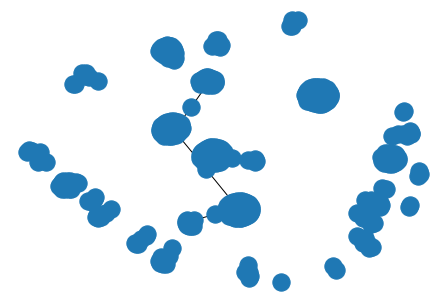

In [58]:
import matplotlib.pyplot as plt
color_state_map = {-1: 'red', 0: 'black', 1: 'blue'}

nx.draw(G)
plt.show()